In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import pickle
import time

In [24]:
#color based segmentation

def combined (img):
    #b, g, r = cv2.split(img)
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    #r_max = g_max = b_max = 255
    r_max = np.amax(r)
    g_max = np.amax(g)
    b_max = np.amax(b)
    #print (r)
    #cv2.imshow("red chaneel",b)

    red_norm = r/r_max
    green_norm = g/g_max
    blue_norm = b/b_max

   # print(red_norm.shape)

    norm = red_norm + blue_norm + green_norm


    small_num = 0.0001
    r = red_norm/(norm+small_num)
    g = green_norm/(norm+small_num)
    b = blue_norm/(norm+small_num)

    #print('normalized r g b values: %d %d %d' %(r, g, b))

    ExG = 2*g - r - b #excess green

    #ExGR = ExG -1.4*r - g #excess green minus red

    #CIVE = 0.441*r - 0.811*g + 0.385*b + 18.78745 #color index of vegetation extraction

    #redistribute the weights without VEG
    #w_ExG = 0.28
    #w_ExGR = 0.34
    #w_CIVE = 0.38

    #combined = w_ExG * ExG + w_ExGR * ExGR + w_CIVE * CIVE

    return ExG


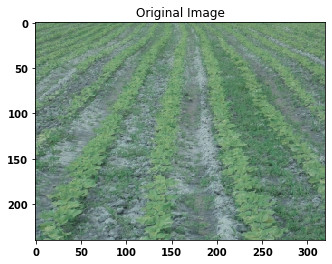

orig. img shape (240, 320, 3)


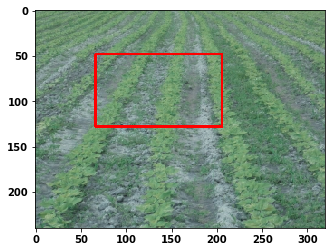

crop img shape (80, 140, 3)


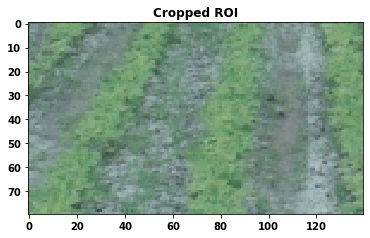

In [25]:
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_055.jpg') #img55: 4 rows, no weed
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_127.jpg') #img127: 3 rows, no weed, intermittent crop growth
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_079.jpg') #img079: 3 curved rows, early crop growth, high weed pressure
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_015.jpg') #img015 : 4 rows, extremely high weed growth, weed and row connected
img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_160.jpg')


%matplotlib inline
plt.imshow(img)
plt.title('Original Image')
plt.show()
#cv2.imshow('sample image',img)

print('orig. img shape',img.shape) #[0] Height, [1] Width, [2] Channel

height = img.shape[0]
width = img.shape[1]

#img127: int(width / 3)
upper_left = (int(width / 3 - 40), int(height / 5)) 
bottom_right = (int(100 + width / 3), int(80 + height / 5))

# draw in the image
roi = img.copy()
roi = cv2.rectangle(roi, upper_left, bottom_right, (255, 0, 0), 2)
#cv2.imshow('Roi line img', roi)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.imshow(roi)
#plt.title('Original image with ROI',fontweight='bold')
plt.savefig(r'C:\Users\khan1\jupyter_test_code\IoU_test\roi\roi_img160.png',bbox_inches='tight')
plt.show()



#crop ROI
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall
print('crop img shape',crop_img.shape)

plt.imshow(crop_img)
plt.title('Cropped ROI',fontweight='bold')

#plt.savefig('img015_2.png', bbox_inches='tight')
plt.show()

 


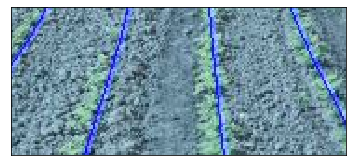

In [61]:
#gt_img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\IoU_test\GT\crop_row_160_GT.jpg')
gt_img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\IoU_value\GT_jpg_new\crop_row_230_GT.jpg')

#crop ROI
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#gtcrop_img = gt_img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall

plt.imshow(gtcrop_img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig(r'C:\Users\khan1\jupyter_test_code\IoU_value\challenge_scene\roi_gt_challenge\roi_gt_img230.png',bbox_inches='tight')
plt.show()

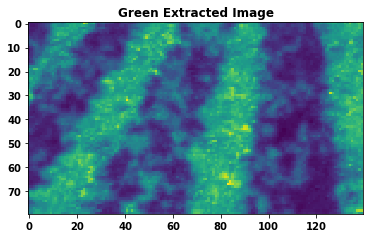

threshold value 95.0


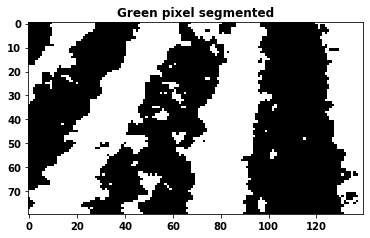

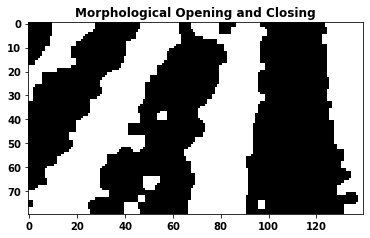

number of data points: 4888


In [27]:
#apply color based segmentation
img = crop_img

max_value = np.max(combined(img))
min_value = np.min(combined(img))
#mapped combined image value (which is mostly negative) to 0-255
new_min = 0
new_max = 255
old_range = max_value - min_value
new_range = new_max - new_min
lin_map = (((combined(img).astype(np.float64) - min_value) * new_range) / old_range) + new_min
image_map = lin_map.astype(np.uint8)
#cv2.imshow("Green Extracted Image", image_map)
plt.imshow(image_map)
plt.title('Green Extracted Image',fontweight='bold')
plt.show()

#OTSU thresholed image
thresh_val,thresh_img = cv2.threshold(image_map,0,255,cv2.THRESH_OTSU)
print('threshold value',thresh_val)
#cv2.imshow('threshhold image', thresh_img)
plt.imshow(thresh_img, cmap='gray')
plt.title('Green pixel segmented',fontweight='bold')
#plt.savefig('img015_3.png', bbox_inches='tight')
plt.show()


#Morphology Opening-Closing to delete small weed segments
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

#cv2.imshow('Open-Close cleaned image', closing)
plt.imshow(closing, cmap='gray')
plt.title('Morphological Opening and Closing',fontweight='bold')
#plt.savefig('img015_4.png', bbox_inches='tight')
plt.show()

#all the white pixel coordinates in segemented image after noise clean
all_pixel = closing.copy()
indices = np.where(all_pixel == [255])
#print ('indices',indices)
coordinates = list(zip(indices[0], indices[1]))
#print(type(coordinates))
print('number of data points:',len(coordinates))
# print ([i for i in coordinates])

#save the list of (x,y) to a file
# afile = open(r'C:\Users\khan1\jupyter_test_code\all_img014.pkl', 'wb')
# pickle.dump(coordinates, afile)
# afile.close()

# for x,y in coordinates:
#     plt.scatter(y,x, c='blue') #for better visualization plotted as (y,x)
# plt.title('all points')
# plt.gca().invert_yaxis()
# plt.show()

In [28]:
center_x_y = []

def center_coordinate(c, i, row, col):
# compute the center of the contour area and draw a circle
# representing the center
    M = cv2.moments(c)
    if M["m00"] > 0:
        cX = int(M["m10"] / M["m00"]) + int(col)
        cY = int(M["m01"] / M["m00"]) + int(row)
        # draw the certer circle on the image
        center_x_y.append((cX, cY))
    return center_x_y

<class 'list'>


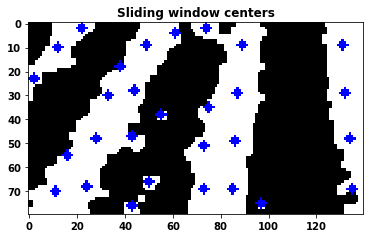

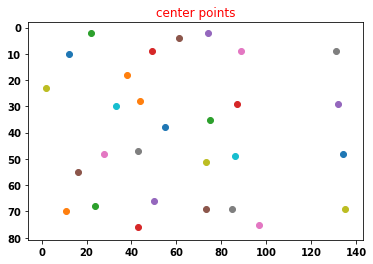

In [29]:
#ROI size
roi_height = closing.shape[0]
roi_width = closing.shape[1]

kernel_h = 20
kernel_w = 20
#slide over image for (kernel_h,kernel_w) window and plot center for that segment

sliding_1 = []
#for ii in range(0,1000):
    #start_time = time.time()
    
for row in range (0, roi_height, kernel_h):
    for col in range (0, roi_width, kernel_w):

        roi_contours, roi_hierarchy = cv2.findContours(closing [int(row):int(row+kernel_h), int(col):int(col+kernel_w)],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        for (i, c) in enumerate(roi_contours):
            x_y = center_coordinate(c, i, row, col)
    #end_time = time.time()
    #diff = end_time-start_time
    #sliding_1.append(diff)

#print("sliding 1 time: ",np.array(sliding_1).mean())

print(type(x_y))

closing_color_img = cv2.cvtColor(closing, cv2.COLOR_GRAY2BGR)
# y-limit: 0-120
# x-limit: 0-80
for x,y in x_y:
    cv2.circle(closing_color_img, (x, y), 2, (0, 0, 255), -1)
plt.imshow(closing_color_img)
plt.title('Sliding window centers',fontweight='bold')
#plt.savefig('img127_5.png', bbox_inches='tight')
plt.show()

for x,y in x_y:
    plt.scatter(x,y)
plt.title('center points',c='red')
plt.gca().invert_yaxis()
plt.show()

#save the list of (x,y) to a file
# afile = open(r'C:\Users\khan1\jupyter_test_code\img55.pkl', 'wb')
# pickle.dump(x_y, afile)
# afile.close()

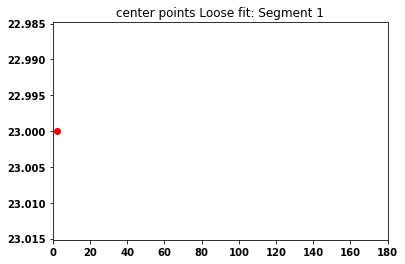

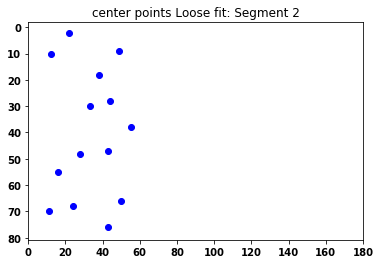

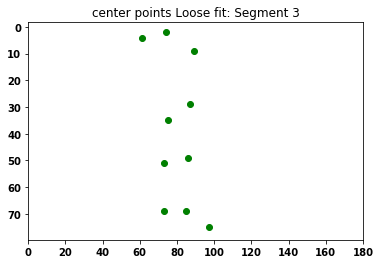

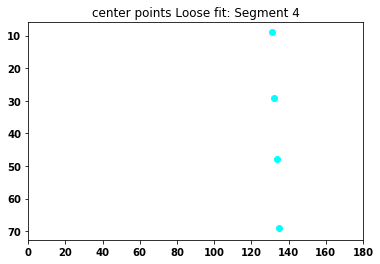

In [30]:
#divide the dataset into multiple column segment so that each segment can fit 1 line
data1 = []
data2 = []
data3 = []
data4 = []

#these segments will change based on our training data
col_segment_1 = 5
col_segment_2 = 60
col_segment_3 = 100
col_segment_4 = 140

for x,y in x_y: #iterate over 'list' x_y
    if x <= col_segment_1:
        data1.append((x,y))
    if col_segment_1 < x < col_segment_2:
        data2.append((x,y))
    if col_segment_2 < x <col_segment_3:
        data3.append((x,y))
    if col_segment_3 < x <col_segment_4:
        data4.append((x,y))



#separate the x and y data for each segment for line fitting
x1data_loose = []
y1data_loose = []

for x1,y1 in data1:
    plt.scatter(x1,y1,c='red')
    x1data_loose.append(x1)
    y1data_loose.append(y1)
plt.title('center points Loose fit: Segment 1')
plt.gca().set_xlim([0,180])
plt.gca().invert_yaxis()
plt.show()

# print(x1data,y1data)
# plt.plot(x1data,y1data,'b-',label='segment 1 data')
# plt.show()

x2data_loose = []
y2data_loose = []

for x2,y2 in data2:
    plt.scatter(x2,y2,c='blue')
    x2data_loose.append(x2)
    y2data_loose.append(y2)
plt.title('center points Loose fit: Segment 2')
plt.gca().set_xlim([0,180])
plt.gca().invert_yaxis()
plt.show()

x3data_loose = []
y3data_loose = []

for x3,y3 in data3:
    plt.scatter(x3,y3,c='green')
    x3data_loose.append(x3)
    y3data_loose.append(y3)
plt.title('center points Loose fit: Segment 3')
plt.gca().set_xlim([0,180])
plt.gca().invert_yaxis()
plt.show()

x4data_loose = []
y4data_loose = []

for x4,y4 in data4:
    plt.scatter(x4,y4,c='cyan')
    x4data_loose.append(x4)
    y4data_loose.append(y4)
plt.title('center points Loose fit: Segment 4')
plt.gca().set_xlim([0,180])
plt.gca().invert_yaxis()
plt.show()


Line fittings are not straight because col_segment is too big. If we use a tighter segment between 50 - 70 instead of 40 -80  (based on knowledge about where the crop row should be), we will have a better line fitting. 
- But how that will afftect the curved crop rows? For curved crop rows, do we know where they start or end?
- What if we segment each col_segment into 20 pixel row_segment (like 0-20, 20-40 ...) then use weighted average (based on area of contour moments) and for wach segment we have only 1 centroid. But if we have crop missing and high weed pressure for a segment, that will give us false row center. How to overcome that?

We need to fit line/cure over x data, because y data is almost straight (vertical) Instead of fitting
coeff =  poly.polyfit(Xdata, Ydata, 1) we have to use,
coeff =  poly.polyfit(Ydata, Xdata, 1)

C:\Users\khan1\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RankWarning: The fit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


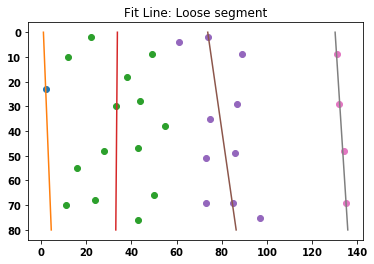

In [31]:
###### Fit line over x data. train on x data ########

coeff_seg1_loose =  poly.polyfit(y1data_loose, x1data_loose, 1)
#print (coeff)
xnew_seg1 = np.linspace(0, 80, 1000)
ffit_seg1 = poly.polyval(xnew_seg1, coeff_seg1_loose)
plt.plot(x1data_loose, y1data_loose, 'o', ffit_seg1, xnew_seg1, '-')

coeff_seg2_loose =  poly.polyfit(y2data_loose, x2data_loose, 1)
xnew_seg2 = np.linspace(0, 80, 1000)
ffit_seg2 = poly.polyval(xnew_seg2, coeff_seg2_loose)
plt.plot(x2data_loose, y2data_loose, 'o', ffit_seg2, xnew_seg2, '-')

coeff_seg3_loose =  poly.polyfit(y3data_loose, x3data_loose, 1)
xnew_seg3 = np.linspace(0, 80, 1000)
ffit_seg3 = poly.polyval(xnew_seg3, coeff_seg3_loose)
plt.plot(x3data_loose, y3data_loose, 'o', ffit_seg3, xnew_seg3, '-')

coeff_seg4_loose =  poly.polyfit(y4data_loose, x4data_loose, 1)
xnew_seg4 = np.linspace(0, 80, 1000)
ffit_seg4 = poly.polyval(xnew_seg4, coeff_seg4_loose)
plt.plot(x4data_loose, y4data_loose, 'o', ffit_seg4, xnew_seg4, '-')

plt.title('Fit Line: Loose segment')
#plt.gca().set_xlim([0,120])
plt.gca().invert_yaxis()
plt.show()

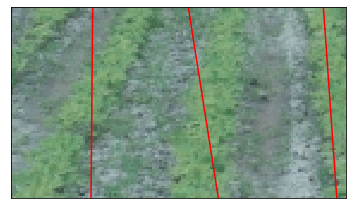

In [32]:
############# Show lines over Crop Image#############

#plt.plot(ffit_seg1, xnew_seg1,'-',color='red')
plt.plot(ffit_seg2, xnew_seg2,'-',color='red')
plt.plot(ffit_seg3, xnew_seg3,'-',color='red')
plt.plot(ffit_seg4, xnew_seg4,'-',color='red')
#plt.legend()
#plt.gca().set_xlim([0,120])
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.imshow(crop_img)
#plt.title('Crop row lines',fontweight='bold')
#plt.savefig(r'C:\Users\khan1\jupyter_test_code\IoU_test\sliding_window\slide_img160.png',bbox_inches='tight')
plt.show()

Need to resolve the following problems:
- How to get better segments (areas where we find rows)? Is it from training images? Can we use a clustering algorithm to defferentiate rows from outliers?
- How to know when to fit straight or curved lines?

In [33]:
cv2.waitKey(0) # waits until a key is pressed
cv2.destroyAllWindows()